In [0]:
# Experiment 1
# Source data - MNIST with patches
# Target data - MNIST without patches

# In this experiment, we train the CNN on the source data and test it on the target data
# For the given CNN architecture, test accuracy is 100% (for 3*3 patch); % 99(for 28*3 patch)

In [0]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

In [0]:
# Accessing index of data of interest
indx_train = trainset.targets < 2
indx_test = testset.targets < 2

trainset.data = trainset.data[indx_train]
trainset.targets = trainset.targets[indx_train]
testset.data = testset.data[indx_test]
testset.targets = testset.targets[indx_test]

# # adding a 3 X 3 white path to the right corner for 1s and left corner for 0s
indx0_train = np.where(trainset.targets == 0)[0].tolist()
indx1_train = np.where(trainset.targets == 1)[0].tolist()
# indx0_test =  np.where(testset.targets == 0)[0].tolist()
# indx1_test =  np.where(testset.targets == 1)[0].tolist()

for ind in indx0_train:
  # Add a white square patch
#   trainset.data[ind][0,0], trainset.data[ind][0,1], trainset.data[ind][0,2], trainset.data[ind][1,0], trainset.data[ind][1,1],\
#   trainset.data[ind][1,2], trainset.data[ind][2,0], trainset.data[ind][2,1], trainset.data[ind][2,2] = 255, 255, 255, 255, 255, 255, 255,\
#   255, 255
  # Add a long white patch
  for i in range(28):
    for j in range(3):
      trainset.data[ind][i, j] = 255
for ind in indx1_train:
#   trainset.data[ind][0,25], trainset.data[ind][0,26], trainset.data[ind][0,27], trainset.data[ind][1,25], trainset.data[ind][1,26],\
#   trainset.data[ind][1,27], trainset.data[ind][2,25], trainset.data[ind][2,26], trainset.data[ind][2,27] = 255, 255, 255, 255, 255, 255, 255,\
#   255, 255
  # Add a long white patch
  for i in range(28):
    for j in range(25, 28):
      trainset.data[ind][i, j] = 255

# for ind in indx0_test:
# #   testset.data[ind][0,0], testset.data[ind][0,1], testset.data[ind][0,2], testset.data[ind][1,0], testset.data[ind][1,1],\
# #   testset.data[ind][1,2], testset.data[ind][2,0], testset.data[ind][2,1], testset.data[ind][2,2] = 255, 255, 255, 255, 255, 255, 255,\
# #   255, 255
#   # Add a long white patch
#   for i in range(28):
#     for j in range(3):
#       testset.data[ind][i, j] = 255

# for ind in indx1_test:
# #   testset.data[ind][0,25], testset.data[ind][0,26], testset.data[ind][0,27], testset.data[ind][1,25], testset.data[ind][1,26],\
# #   testset.data[ind][1,27], testset.data[ind][2,25], testset.data[ind][2,26], testset.data[ind][2,27] = 255, 255, 255, 255, 255, 255, 255,\
# #   255, 255
#   # Add a long white patch
#   for i in range(28):
#     for j in range(25, 28):
#       testset.data[ind][i, j] = 255


In [0]:
# Assign data to data loader

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False, num_workers = 2)

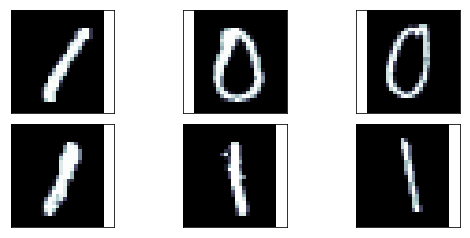

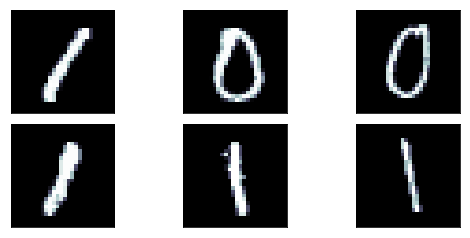

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Plot random train and test images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 55, 500, 577, 1000, 1122], axes.flat):
    ax.imshow(trainset.data[i], cmap='bone')
    
    
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 55, 500, 577, 1000, 1122], axes.flat):
    ax.imshow(testset.data[i], cmap='bone')    

In [0]:
# Define the Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, 5)
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64, 50, 5)
    self.batch_norm2 = nn.BatchNorm2d(50)
    self.fc1 = nn.Linear(50*4*4, 100)
#    self.fc2 = nn.Linear(120, 100)
    self.fc3 = nn.Linear(100, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
    x = x.view(-1, 50*4*4)
    x = F.relu(self.fc1(x))
#    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()  

In [0]:
# Define loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [9]:
# Train the network

n_epochs = 5

for epoch in range(n_epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader):
    inputs, labels = data
    
    # Set the gradients to zero
    optimizer.zero_grad()
    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()
  print(running_loss)  
#     if i % 100 == 0:
#       print('[%d, %5d] loss : %.3f' %(epoch + 1, i + 1, running_loss))
#       #running_loss = 0
print('finished training!')      

6.041563225811842
0.0019286469669168582
0.0006525140058784018
0.0003244665108184108
0.00018073226276271726
finished training!


In [10]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 99 %
